# "An RL Approach for Inventory Management (Part 11)"

> Tabular Temporal-Difference (Q-Learning) Control
- toc: true
- branch: master
- badges: false
- comments: true
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2
- image: images/InventoryManagement11.png
- categories: [Inventory_Management,   Markov_Decision_Process,   TD,QLearning]
- show_tags: true

In [ ]:
# hide
# based on 0^td_ql_simple_inventory_mdp_cap_KE.ipynb

## 1 Generalized Policy Iteration (GPI)

In previous projects we have only dealt with the *prediction* problem. In this project we move on to the *control* problem. We stay in the *model-free* or *learning* domain (rather than *planning*), i.e. making use of Reinforcement Learning algorithms. We will explore the *depth of update* dimension, considering both *bootstrapping* and *non-bootstrapping* methods like Temporal-Difference (TD) and Monte-Carlo (MC) algorithms respectively.

What is different about Control, rather than Prediction, is the depence on the concept of Generalized Policy Iteration (GPI). 

The key concept of GPI is that we can:
- Evaluate a policy with *any* Policy Evaluation method
- Improve a policy with *any* Policy Improvement method

## 2 Off-Policy Control

For all control algorithms there is a conflict between trying to learn Q-Values that associated with optimal behavior and the need to explore all actions. How do we address this?

- Our approach so far (which is a hack)
  - pursue an $\epsilon$-greedy policy
  - *almost optimal* policy
- Better, cleaner approach
  - Two policies, one for each competing interest
    - *Target Policy* $\pi$
      - the target of Control
      - learn about this policy
      - becomes optimal policy eventually
    - *Behavior Policy* $\mu$
      - behaves in an exploratory manner
      - allows for sufficient data for all actions
      - enables adequate estimate of the Q-Value Function
  - Known as *off-policy* algorithms
  - Allows for more general and more powerful RL slgorithms
  - Off-Policy algorithm
    - estimate the Value Function for target policy $\pi$ while it
    - follows behavior policy $\mu$
  - Advantages of Off-Policy algorithms
    - can learn the target policy $\pi$ by observing humans or other AI agents who follow a behavior policy $\mu$
    - can re-use prior experiences that were genrated from old policies, say $\pi_1, \pi_2, ...$



## 3 Q-Learning

To get to the Q-Learning algorithm we tweak the SARSA algorithm to make it Off-Policy.

First tweak:
- Instead of generating
  - both action $A$ and next action $A'$ by the 
  - same $\epsilon$-greedy policy
- we generate
  - action $A$ using (exploratory) behavior policy $\mu$
  - next action $A'$ using target policy $\pi$

Second tweak:
- Instead of advancing to the next time step by
  - setting $S_{t+1}$ to $S'_t$ and $A_{t+1}$ to $A'_t$
- we advance by
  - only setting $S_{t+1}$ to $S'_t$ while $A_{t+1}$ is generated using the behavior policy $\mu$

In [ ]:
#hide
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive"
base_dir = root_dir + '/Rao_CME241/RL-book'

Mounted at /content/gdrive


In [ ]:
!python --version

Python 3.7.15


In [ ]:
# hide
base_dir

'/content/gdrive/My Drive/Rao_CME241/RL-book'

In [ ]:
# hide
import sys
sys.path

['/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython']

In [ ]:
# hide
# sys.path.insert(0, f"{base_dir}/gen_utils"); sys.path
sys.path.append(f"{base_dir}"); sys.path

['/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/gdrive/My Drive/Rao_CME241/RL-book']

In [ ]:
from typing import Callable, Iterator, Tuple, Mapping
import itertools
import inspect
from pprint import pprint

In [ ]:
# hide
from rl.distribution_ANNO import (Constant, Choose, Categorical)
import rl.iterate_ANNO as iterate
from rl.markov_process_ANNO import NonTerminal
from rl.markov_decision_process_ANNO import (
    FiniteMarkovDecisionProcess, 
    MarkovDecisionProcess, 
    S, 
    A,
    Policy
)
from rl.dynamic_programming_ANNO import (value_iteration_result, V)
from rl.approximate_dynamic_programming_ANNO import (QValueFunctionApprox, NTStateDistribution)
from rl.function_approx_ANNO import (Tabular, learning_rate_schedule)
from rl.policy_ANNO import (
    FiniteDeterministicPolicy, 
    RandomPolicy, 
    DeterministicPolicy, 
    UniformPolicy)
import rl.monte_carlo_ANNO as mc

from rl.book45_github3.simple_inventory_mdp_cap import (SimpleInventoryMDPCap, InventoryState)
# # from rl.book12_github11.control_utils_ANNO import (
# #     glie_mc_finite_learning_rate_correctness,
# #     q_learning_finite_learning_rate_correctness,
# #     glie_sarsa_finite_learning_rate_correctness,
# #     compare_mc_sarsa_ql
# # )

## 4 Temporal-Difference (TD) Control (Q-Learning)

We need to ensure that the target policy eventually turns into the optimal policy. A straightforward way to do this is to have the target policy equal to the deterministic greedy policy derived from the Q-Value Function estimate at each step. This leads to the parameter update:

$$
\begin{aligned}
\Delta w &= \alpha \cdot \delta_t \cdot \nabla_w Q(S_t,A_t;w)
\end{aligned}
$$

where

$$
\begin{aligned}
\delta_t &= R_{t+1} + \gamma \cdot Q(S_{t+1}, \underset{a \in \mathcal A}{\text{ arg max}}Q(S_{t+1},a;w);w) - Q(S_t,A_t;w) \\
&= R_{t+1} + \gamma \cdot \underset{a \in \mathcal A}{\text{max}} Q(S_{t+1},a;w) - Q(S_t,A_t;w)) 
\end{aligned}
$$

### 4.1 Implementation of Temporal_Difference (Q-Learning) Control

In [ ]:
PolicyFromQType = Callable[
    [QValueFunctionApprox[S, A], MarkovDecisionProcess[S, A]],
    Policy[S, A]
]

In [ ]:
def q_learning(
    mdp: MarkovDecisionProcess[S, A],
    policy_from_q: PolicyFromQType,
    states: NTStateDistribution[S],
    approx_0: QValueFunctionApprox[S, A],
    γ: float,
    max_episode_length: int
) -> Iterator[QValueFunctionApprox[S, A]]:
    q: QValueFunctionApprox[S, A] = approx_0
    yield q
    while True:
        state: NonTerminal[S] = states.sample()
        steps: int = 0
        while isinstance(state, NonTerminal) and steps < max_episode_length:
            policy: Policy[S, A] = policy_from_q(q, mdp)
            action: A = policy.act(state).sample()
            #. next_state, reward = mdp.step(state, action).sample()
            next_state, reward = mdp.transition_action(state, action).sample() #.
            next_return: float = max(
                q((next_state, a))
                for a in mdp.actions(next_state)
            ) if isinstance(next_state, NonTerminal) else 0.
            q = q.update([((state, action), reward + γ * next_return)])
            yield q
            steps += 1
            state = next_state

We run the TAB TD Control (Q-Learning) algorithm on the Inventory problem.

In [ ]:
# hide
inspect.getmro(SimpleInventoryMDPCap)

(rl.book45_github3.simple_inventory_mdp_cap.SimpleInventoryMDPCap,
 rl.markov_decision_process_ANNO.FiniteMarkovDecisionProcess,
 rl.markov_decision_process_ANNO.MarkovDecisionProcess,
 abc.ABC,
 typing.Generic,
 object)

Let us set the capacity $C=5$, but keep the other parameters as before.

In [ ]:
# capacity: int = 2
capacity: int = 5
poisson_lambda: float = 1.0
holding_cost: float = 1.0
stockout_cost: float = 10.0
gamma: float = 0.9

In [ ]:
si_mdp: SimpleInventoryMDPCap = SimpleInventoryMDPCap(
    capacity=capacity,
    poisson_lambda=poisson_lambda,
    holding_cost=holding_cost,
    stockout_cost=stockout_cost
)

In [ ]:
max_episode_length: int = 100
# epsilon_as_func_of_episodes: Callable[[int], float] = lambda k: k**-0.5
initial_learning_rate: float = 0.1
half_life: float = 10000.0
exponent: float = 1.0
# gamma: float = 0.9
q_learning_epsilon: float = 0.2

In [ ]:
initial_qvf_dict: Mapping[Tuple[NonTerminal[InventoryState], int], float] = {
    (s, a): 0. for s in si_mdp.non_terminal_states for a in si_mdp.actions(s)
}
# initial_qvf_dict

In [ ]:
learning_rate_func: Callable[[int], float] = learning_rate_schedule(
    initial_learning_rate=initial_learning_rate,
    half_life=half_life,
    exponent=exponent
)

In [ ]:
qvfas: Iterator[QValueFunctionApprox[InventoryState, int]] = q_learning(
        mdp=si_mdp,
        policy_from_q=lambda f, m: mc.epsilon_greedy_policy(
            q=f,
            mdp=m,
            ϵ=q_learning_epsilon
        ),
        states=Choose(si_mdp.non_terminal_states),
        approx_0=Tabular(
            values_map=initial_qvf_dict,
            count_to_weight_func=learning_rate_func
        ),
        γ=gamma,
        max_episode_length=max_episode_length
)
qvfas

<generator object q_learning at 0x7fccc04f44d0>

Now we get the final estimate of the Optimal Action-Value Function after n_episodes*max_episode_length. Then we extract from it the estimate of the Optimal State-Value Function and the Optimal Policy.

In [ ]:
n_episodes = 10_000
n_updates = n_episodes*max_episode_length

In [ ]:
%%time
qvfa_lst = [qvfa for qvfa in itertools.islice(qvfas, n_updates)]

CPU times: user 2min 52s, sys: 13.3 s, total: 3min 6s
Wall time: 2min 55s


In [ ]:
final_qvfa: QValueFunctionApprox[InventoryState, int] = iterate.last(qvfa_lst)

In [ ]:
final_qvfa

Tabular(values_map={(NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 0): -34.29167989362301, (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 1): -28.019374282761202, (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 2): -26.963364564912712, (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 3): -28.069960994856284, (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 4): -28.869247283981043, (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 5): -30.556181243287856, (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), 0): -25.153238171832434, (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), 1): -20.281394896688038, (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), 2): -19.950928140606013, (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), 3): -20.784684662015437, (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), 4): -22.093641772523796, (NonTerminal(state=InventoryState(on_hand=0, on_order=2))

In [ ]:
def get_vf_and_policy_from_qvf(
    mdp: FiniteMarkovDecisionProcess[S, A],
    qvf: QValueFunctionApprox[S, A]
) -> Tuple[V[S], FiniteDeterministicPolicy[S, A]]:
    opt_vf: V[S] = {
        s: max(qvf((s, a)) for a in mdp.actions(s))
        for s in mdp.non_terminal_states
    }
    opt_policy: FiniteDeterministicPolicy[S, A] = \
        FiniteDeterministicPolicy({
            s.state: qvf.argmax((s, a) for a in mdp.actions(s))[1]
            for s in mdp.non_terminal_states
        })
    return opt_vf, opt_policy

In [ ]:
opt_svf, opt_pol = get_vf_and_policy_from_qvf(
    mdp=si_mdp,
    qvf=final_qvfa
)

In [ ]:
print(f"TD (Q-Learning) Optimal Value Function with {n_updates:d} updates")
pprint(opt_svf)

TD (Q-Learning) Optimal Value Function with 1000000 updates
{NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -26.963364564912712,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -19.950928140606013,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -18.893096534914584,
 NonTerminal(state=InventoryState(on_hand=0, on_order=3)): -19.766811430911748,
 NonTerminal(state=InventoryState(on_hand=0, on_order=4)): -20.74205917979043,
 NonTerminal(state=InventoryState(on_hand=0, on_order=5)): -23.397969626596268,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -21.099163467139114,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -19.82044156219879,
 NonTerminal(state=InventoryState(on_hand=1, on_order=2)): -20.84792154775406,
 NonTerminal(state=InventoryState(on_hand=1, on_order=3)): -21.83612334536198,
 NonTerminal(state=InventoryState(on_hand=1, on_order=4)): -24.259325423298947,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -20.8

In [ ]:
print(f"TD (Q-Learning) Optimal Policy with {n_updates:d} updates")
pprint(opt_pol)

TD (Q-Learning) Optimal Policy with 1000000 updates
For State InventoryState(on_hand=0, on_order=0): Do Action 2
For State InventoryState(on_hand=0, on_order=1): Do Action 2
For State InventoryState(on_hand=0, on_order=2): Do Action 1
For State InventoryState(on_hand=0, on_order=3): Do Action 1
For State InventoryState(on_hand=0, on_order=4): Do Action 0
For State InventoryState(on_hand=0, on_order=5): Do Action 0
For State InventoryState(on_hand=1, on_order=0): Do Action 2
For State InventoryState(on_hand=1, on_order=1): Do Action 1
For State InventoryState(on_hand=1, on_order=2): Do Action 1
For State InventoryState(on_hand=1, on_order=3): Do Action 0
For State InventoryState(on_hand=1, on_order=4): Do Action 0
For State InventoryState(on_hand=2, on_order=0): Do Action 1
For State InventoryState(on_hand=2, on_order=1): Do Action 1
For State InventoryState(on_hand=2, on_order=2): Do Action 0
For State InventoryState(on_hand=2, on_order=3): Do Action 0
For State InventoryState(on_hand=

For comparison, we run a Value Iteration to find the *true* Optimal Value Function and Optimal Policy.

In [ ]:
true_opt_svf, true_opt_pol = value_iteration_result(mdp=si_mdp, gamma=gamma)

In [ ]:
print("True Optimal State Value Function")
pprint(true_opt_svf)

True Optimal State Value Function
{NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -26.98163492786722,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -19.9909558006178,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -18.86849301795165,
 NonTerminal(state=InventoryState(on_hand=0, on_order=3)): -19.934022635857023,
 NonTerminal(state=InventoryState(on_hand=0, on_order=4)): -20.91848526863397,
 NonTerminal(state=InventoryState(on_hand=0, on_order=5)): -22.77205311116058,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -20.9909558006178,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -19.86849301795165,
 NonTerminal(state=InventoryState(on_hand=1, on_order=2)): -20.934022635857026,
 NonTerminal(state=InventoryState(on_hand=1, on_order=3)): -21.918485268633972,
 NonTerminal(state=InventoryState(on_hand=1, on_order=4)): -23.77205311116058,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -20.86849301795165,
 NonTerminal(stat

In [ ]:
print("True Optimal Policy")
pprint(true_opt_pol)

True Optimal Policy
For State InventoryState(on_hand=0, on_order=0): Do Action 2
For State InventoryState(on_hand=0, on_order=1): Do Action 2
For State InventoryState(on_hand=0, on_order=2): Do Action 1
For State InventoryState(on_hand=0, on_order=3): Do Action 1
For State InventoryState(on_hand=0, on_order=4): Do Action 0
For State InventoryState(on_hand=0, on_order=5): Do Action 0
For State InventoryState(on_hand=1, on_order=0): Do Action 2
For State InventoryState(on_hand=1, on_order=1): Do Action 1
For State InventoryState(on_hand=1, on_order=2): Do Action 1
For State InventoryState(on_hand=1, on_order=3): Do Action 0
For State InventoryState(on_hand=1, on_order=4): Do Action 0
For State InventoryState(on_hand=2, on_order=0): Do Action 1
For State InventoryState(on_hand=2, on_order=1): Do Action 1
For State InventoryState(on_hand=2, on_order=2): Do Action 0
For State InventoryState(on_hand=2, on_order=3): Do Action 0
For State InventoryState(on_hand=3, on_order=0): Do Action 1
For 

Now we compare values by state for the State Value Function

In [ ]:
[(true_opt_svf[s], opt_svf[s]) for s in si_mdp.non_terminal_states]

[(-26.98163492786722, -26.963364564912712),
 (-19.9909558006178, -19.950928140606013),
 (-18.86849301795165, -18.893096534914584),
 (-19.934022635857023, -19.766811430911748),
 (-20.91848526863397, -20.74205917979043),
 (-22.77205311116058, -23.397969626596268),
 (-20.9909558006178, -21.099163467139114),
 (-19.86849301795165, -19.82044156219879),
 (-20.934022635857026, -20.84792154775406),
 (-21.918485268633972, -21.83612334536198),
 (-23.77205311116058, -24.259325423298947),
 (-20.86849301795165, -20.84338106185867),
 (-21.934022635857023, -21.995874198463067),
 (-22.91848526863397, -22.875950561803087),
 (-24.77205311116058, -24.787545606776312),
 (-22.934022635857026, -22.929466105679385),
 (-23.918485268633972, -24.078312289662236),
 (-25.772053111160584, -26.058681205609766),
 (-24.91848526863397, -25.071399529390735),
 (-26.772053111160577, -26.853538764992972),
 (-27.772053111160577, -27.74356947452911)]

We also compare values by state for the Policy

In [ ]:
[(true_opt_pol.policy_map[s.state], opt_pol.policy_map[s.state]) for s in si_mdp.non_terminal_states]

[(Constant(value=2), Constant(value=2)),
 (Constant(value=2), Constant(value=2)),
 (Constant(value=1), Constant(value=1)),
 (Constant(value=1), Constant(value=1)),
 (Constant(value=0), Constant(value=0)),
 (Constant(value=0), Constant(value=0)),
 (Constant(value=2), Constant(value=2)),
 (Constant(value=1), Constant(value=1)),
 (Constant(value=1), Constant(value=1)),
 (Constant(value=0), Constant(value=0)),
 (Constant(value=0), Constant(value=0)),
 (Constant(value=1), Constant(value=1)),
 (Constant(value=1), Constant(value=1)),
 (Constant(value=0), Constant(value=0)),
 (Constant(value=0), Constant(value=0)),
 (Constant(value=1), Constant(value=1)),
 (Constant(value=0), Constant(value=0)),
 (Constant(value=0), Constant(value=0)),
 (Constant(value=0), Constant(value=0)),
 (Constant(value=0), Constant(value=0)),
 (Constant(value=0), Constant(value=0))]

### 4.2 Visualize

Let us visualize the convergence of the Action Value Function (Q) for each of the states:

In [ ]:
qvfa_lst[10]

Tabular(values_map={(NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 0): -1.0, (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 1): -1.0, (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 2): 0.0, (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 3): 0.0, (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 4): 0.0, (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 5): 0.0, (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), 0): 0.0, (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), 1): 0.0, (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), 2): 0.0, (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), 3): 0.0, (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), 4): 0.0, (NonTerminal(state=InventoryState(on_hand=0, on_order=2)), 0): 0.0, (NonTerminal(state=InventoryState(on_hand=0, on_order=2)), 1): 0.0, (NonTerminal(state=InventoryState(on_hand=0, on_order=2)), 2): 0.0, (NonTerminal(state=Invento

In [ ]:
qvfa_lst[10].values_map

{(NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 0): -1.0,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 1): -1.0,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 2): 0.0,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 3): 0.0,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 4): 0.0,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 5): 0.0,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), 0): 0.0,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), 1): 0.0,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), 2): 0.0,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), 3): 0.0,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), 4): 0.0,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=2)), 0): 0.0,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=2)), 1): 0.0,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=2)), 2): 0.0,
 (NonTerminal(state=InventorySta

In [ ]:
qvfa_lst[10].counts_map

{(NonTerminal(state=InventoryState(on_hand=2, on_order=2)), 0): 1,
 (NonTerminal(state=InventoryState(on_hand=4, on_order=0)), 0): 1,
 (NonTerminal(state=InventoryState(on_hand=3, on_order=0)), 0): 1,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 0): 1,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 1): 1,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), 4): 1,
 (NonTerminal(state=InventoryState(on_hand=1, on_order=4)), 0): 1,
 (NonTerminal(state=InventoryState(on_hand=3, on_order=0)), 1): 1,
 (NonTerminal(state=InventoryState(on_hand=2, on_order=1)), 2): 1,
 (NonTerminal(state=InventoryState(on_hand=2, on_order=2)), 1): 1}

Let us visualize how the Action Value Function for each (state, action) pair converges during the operation of the Monte-Carlo algorithm.

In [ ]:
values_dicts = [(vfa.values_map) for vfa in qvfa_lst]
# values_dicts

In [ ]:
# https://stackoverflow.com/questions/5946236/how-to-merge-dicts-collecting-values-from-matching-keys
from collections import defaultdict
ds = values_dicts
merged_dict = defaultdict(list)
for d in ds: #input dicts
    for key, value in d.items():
        merged_dict[key].append(value)
# merged_dict

In [ ]:
len(merged_dict)

56

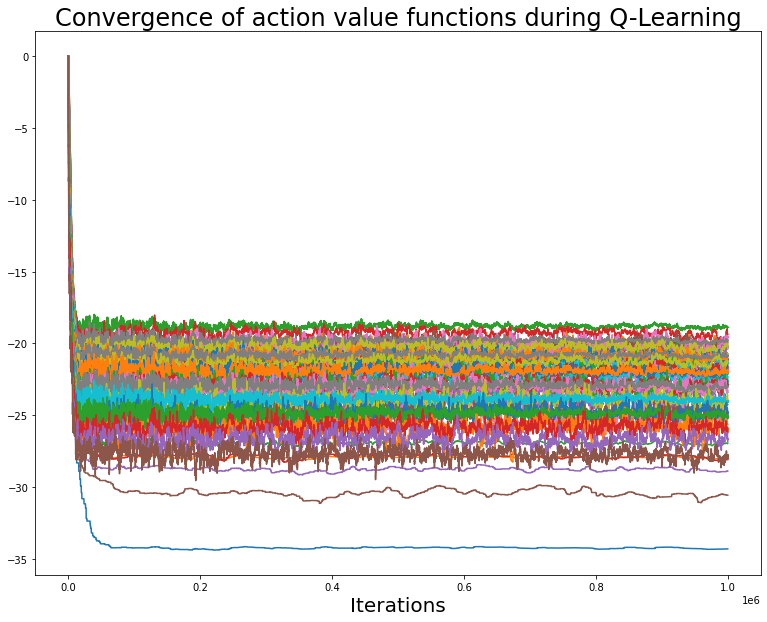

In [ ]:
import matplotlib.pyplot as plt
fig,axs = plt.subplots(figsize=(13,10))
axs.set_xlabel('Iterations', fontsize=20)
axs.set_title(f'Convergence of action value functions during Q-Learning', fontsize=24)
for it in merged_dict.items():
  axs.plot(it[1], label=f'{it[0][0].state}, {it[0][1]}')
# axs.legend(fontsize=15);

In [ ]:
# hide
# Next we visualize the number of visits for each (state, action) pair during the operation of the Monte-Carlo algorithm.

In [ ]:
# hide
# # for sake of RAM
# counts_dicts = [(vfa.counts_map) for vfa in qvfa_lst]
# # values_dicts

In [ ]:
# hide
# # https://stackoverflow.com/questions/5946236/how-to-merge-dicts-collecting-values-from-matching-keys
# from collections import defaultdict
# ds = counts_dicts
# merged_dict = defaultdict(list)
# for d in ds: #input dicts
#     for key, value in d.items():
#         merged_dict[key].append(value)
# # merged_dict

In [ ]:
# hide
# len(merged_dict)

In [ ]:
# hide
# import matplotlib.pyplot as plt
# fig,axs = plt.subplots(figsize=(13,10))
# axs.set_xlabel('Iterations', fontsize=20)
# axs.set_title(f'Visits to each (state, action) pair during Q-Learning', fontsize=24)
# for it in merged_dict.items():
#   axs.plot(it[1], label=f'{it[0][0].state}, {it[0][1]}')
# axs.legend(fontsize=15);

### 3.5 Performance of optimal policy vs other policies

In [ ]:
import numpy as np

In [ ]:
print('capacity =', capacity)
print('poisson_lambda =', poisson_lambda) 
print('holding_cost =', holding_cost)
print('stockout_cost =', stockout_cost)
print('gamma =', gamma)

capacity = 5
poisson_lambda = 1.0
holding_cost = 1.0
stockout_cost = 10.0
gamma = 0.9


In [ ]:
n_steps = 2_000 #number of simulation steps

In [ ]:
class SimpleInventoryDeterministicPolicy(DeterministicPolicy[InventoryState, int]):
  def __init__(self, reorder_point: int):
    self.reorder_point: int = reorder_point
    def action_for(s: InventoryState) -> int:
      return max(self.reorder_point - s.inventory_position(), 0)
    super().__init__(action_for)

In [ ]:
# 
# start state distribution
ssd = Choose(si_mdp.non_terminal_states)
# ssd

#### 3.5.1 Deterministic Policy with Reorder Point set to Capacity (Maximum Inventory)

$\theta = \text{max}(r - (\alpha + \beta), 0)$

where:
  - $\theta \in \mathbb Z_{\ge0}$ is the order quantity
  - $r \in \mathbb Z_{\ge0}$ is the reorder point below which reordering is allowed.
  - $\alpha$ is the on-hand inventory
  - $\beta$ is the on-order inventory
  - $(\alpha,\beta)$ is the state

We set $r = C$ where $C$ is the inventory capacity for the item.

In [ ]:
reorder_point_pol_1 = capacity; reorder_point_pol_1

5

In [ ]:
pol_1 = SimpleInventoryDeterministicPolicy(reorder_point=reorder_point_pol_1); pol_1

SimpleInventoryDeterministicPolicy(action_for=<function SimpleInventoryDeterministicPolicy.__init__.<locals>.action_for at 0x7fcccc7f4d40>)

In [ ]:
step_gen = si_mdp.simulate_action(
    start_state_distribution=ssd, 
    policy=pol_1) 

In [ ]:
step_lst = list(itertools.islice(step_gen, n_steps))
pprint(step_lst[:5])

[TransitionStep(state=NonTerminal(state=InventoryState(on_hand=4, on_order=1)), action=0, next_state=NonTerminal(state=InventoryState(on_hand=5, on_order=0)), reward=-4.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=5, on_order=0)), action=0, next_state=NonTerminal(state=InventoryState(on_hand=0, on_order=0)), reward=-5.006889227394354),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=0, on_order=0)), action=5, next_state=NonTerminal(state=InventoryState(on_hand=0, on_order=5)), reward=-10.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=0, on_order=5)), action=0, next_state=NonTerminal(state=InventoryState(on_hand=5, on_order=0)), reward=-0.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=5, on_order=0)), action=0, next_state=NonTerminal(state=InventoryState(on_hand=5, on_order=0)), reward=-5.0)]


In [ ]:
list_of_tuples = [((step.state.state.on_hand,step.state.state.on_order), step.action, (step.next_state.state.on_hand,step.next_state.state.on_order), step.reward) for step in step_lst]
# list_of_tuples

In [ ]:
states, actions, next_states, rewards = [list(tup) for tup in zip(*list_of_tuples)]

In [ ]:
cum_reward_pol_1 = np.cumsum(rewards)

#### 3.5.2 Deterministic Policy with Reorder Point set to 1 (Minimum Inventory)

$\theta = \text{max}(r - (\alpha + \beta), 0)$

where:
  - $\theta \in \mathbb Z_{\ge0}$ is the order quantity
  - $r \in \mathbb Z_{\ge0}$ is the reorder point below which reordering is allowed.
  - $\alpha$ is the on-hand inventory
  - $\beta$ is the on-order inventory
  - $(\alpha,\beta)$ is the state

We set $r = 1$.

In [ ]:
reorder_point_pol_2 = 1; reorder_point_pol_2

1

In [ ]:
pol_2 = SimpleInventoryDeterministicPolicy(reorder_point=reorder_point_pol_2); pol_2

SimpleInventoryDeterministicPolicy(action_for=<function SimpleInventoryDeterministicPolicy.__init__.<locals>.action_for at 0x7fcccc7e9b90>)

In [ ]:
step_gen = si_mdp.simulate_action(
    start_state_distribution=ssd, 
    policy=pol_2) 

In [ ]:
step_lst = list(itertools.islice(step_gen, n_steps))
pprint(step_lst[:5])

[TransitionStep(state=NonTerminal(state=InventoryState(on_hand=0, on_order=0)), action=1, next_state=NonTerminal(state=InventoryState(on_hand=0, on_order=1)), reward=-10.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=0, on_order=1)), action=0, next_state=NonTerminal(state=InventoryState(on_hand=0, on_order=0)), reward=-3.6787944117144233),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=0, on_order=0)), action=1, next_state=NonTerminal(state=InventoryState(on_hand=0, on_order=1)), reward=-10.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=0, on_order=1)), action=0, next_state=NonTerminal(state=InventoryState(on_hand=0, on_order=0)), reward=-3.6787944117144233),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=0, on_order=0)), action=1, next_state=NonTerminal(state=InventoryState(on_hand=0, on_order=1)), reward=-10.0)]


In [ ]:
list_of_tuples = [((step.state.state.on_hand,step.state.state.on_order), step.action, (step.next_state.state.on_hand,step.next_state.state.on_order), step.reward) for step in step_lst]
# list_of_tuples

In [ ]:
states, actions, next_states, rewards = [list(tup) for tup in zip(*list_of_tuples)]

In [ ]:
cum_reward_pol_2 = np.cumsum(rewards)

#### 3.5.3 Deterministic Policy with Reorder Point set to Midpoint (Midpoint Inventory)

$\theta = \text{max}(r - (\alpha + \beta), 0)$

where:
  - $\theta \in \mathbb Z_{\ge0}$ is the order quantity
  - $r \in \mathbb Z_{\ge0}$ is the reorder point below which reordering is allowed.
  - $\alpha$ is the on-hand inventory
  - $\beta$ is the on-order inventory
  - $(\alpha,\beta)$ is the state

We set $r = \frac{C}{2}$.

In [ ]:
reorder_point_pol_3 = capacity//2; reorder_point_pol_3

2

In [ ]:
pol_3 = SimpleInventoryDeterministicPolicy(reorder_point=reorder_point_pol_3); pol_3

SimpleInventoryDeterministicPolicy(action_for=<function SimpleInventoryDeterministicPolicy.__init__.<locals>.action_for at 0x7fcccc7e90e0>)

In [ ]:
step_gen = si_mdp.simulate_action(
    start_state_distribution=ssd, 
    policy=pol_3) 

In [ ]:
step_lst = list(itertools.islice(step_gen, n_steps))
pprint(step_lst[:5])

[TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=3)), action=0, next_state=NonTerminal(state=InventoryState(on_hand=4, on_order=0)), reward=-1.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=4, on_order=0)), action=0, next_state=NonTerminal(state=InventoryState(on_hand=4, on_order=0)), reward=-4.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=4, on_order=0)), action=0, next_state=NonTerminal(state=InventoryState(on_hand=3, on_order=0)), reward=-4.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=3, on_order=0)), action=0, next_state=NonTerminal(state=InventoryState(on_hand=2, on_order=0)), reward=-3.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=2, on_order=0)), action=0, next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), reward=-2.0)]


In [ ]:
list_of_tuples = [((step.state.state.on_hand,step.state.state.on_order), step.action, (step.next_state.state.on_hand,step.next_state.state.on_order), step.reward) for step in step_lst]
# list_of_tuples

In [ ]:
states, actions, next_states, rewards = [list(tup) for tup in zip(*list_of_tuples)]

In [ ]:
cum_reward_pol_3 = np.cumsum(rewards)

#### 3.5.4 Optimal Policy (TD Q-Learning)

In [ ]:
print(f"TD (Q-Learning) Optimal Policy with {n_updates:d} updates")
pprint(opt_pol)

TD (Q-Learning) Optimal Policy with 1000000 updates
For State InventoryState(on_hand=0, on_order=0): Do Action 2
For State InventoryState(on_hand=0, on_order=1): Do Action 2
For State InventoryState(on_hand=0, on_order=2): Do Action 1
For State InventoryState(on_hand=0, on_order=3): Do Action 1
For State InventoryState(on_hand=0, on_order=4): Do Action 0
For State InventoryState(on_hand=0, on_order=5): Do Action 0
For State InventoryState(on_hand=1, on_order=0): Do Action 2
For State InventoryState(on_hand=1, on_order=1): Do Action 1
For State InventoryState(on_hand=1, on_order=2): Do Action 1
For State InventoryState(on_hand=1, on_order=3): Do Action 0
For State InventoryState(on_hand=1, on_order=4): Do Action 0
For State InventoryState(on_hand=2, on_order=0): Do Action 1
For State InventoryState(on_hand=2, on_order=1): Do Action 1
For State InventoryState(on_hand=2, on_order=2): Do Action 0
For State InventoryState(on_hand=2, on_order=3): Do Action 0
For State InventoryState(on_hand=

In [ ]:
type(opt_pol)

rl.policy_ANNO.FiniteDeterministicPolicy

In [ ]:
# hide
# s = si_mdp.non_terminal_states[2]; s

In [ ]:
# hide
# opt_pol.act(s)

In [ ]:
step_gen = si_mdp.simulate_action(
    start_state_distribution=ssd, 
    policy=opt_pol) 

In [ ]:
step_lst = list(itertools.islice(step_gen, n_steps))
pprint(step_lst[:5])

[TransitionStep(state=NonTerminal(state=InventoryState(on_hand=0, on_order=2)), action=1, next_state=NonTerminal(state=InventoryState(on_hand=2, on_order=1)), reward=-0.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=2, on_order=1)), action=1, next_state=NonTerminal(state=InventoryState(on_hand=3, on_order=1)), reward=-2.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=3, on_order=1)), action=0, next_state=NonTerminal(state=InventoryState(on_hand=4, on_order=0)), reward=-3.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=4, on_order=0)), action=0, next_state=NonTerminal(state=InventoryState(on_hand=2, on_order=0)), reward=-4.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=2, on_order=0)), action=1, next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), reward=-2.0)]


In [ ]:
list_of_tuples = [((step.state.state.on_hand,step.state.state.on_order), step.action, (step.next_state.state.on_hand,step.next_state.state.on_order), step.reward) for step in step_lst]
# list_of_tuples

In [ ]:
states, actions, next_states, rewards = [list(tup) for tup in zip(*list_of_tuples)]

In [ ]:
cum_reward_pol_opt = np.cumsum(rewards)

#### 3.5.5 True Optimal Policy

In [ ]:
print(f"TD (Q-Learning) True Optimal Policy with {n_updates:d} updates")
pprint(true_opt_pol)

TD (Q-Learning) True Optimal Policy with 1000000 updates
For State InventoryState(on_hand=0, on_order=0): Do Action 2
For State InventoryState(on_hand=0, on_order=1): Do Action 2
For State InventoryState(on_hand=0, on_order=2): Do Action 1
For State InventoryState(on_hand=0, on_order=3): Do Action 1
For State InventoryState(on_hand=0, on_order=4): Do Action 0
For State InventoryState(on_hand=0, on_order=5): Do Action 0
For State InventoryState(on_hand=1, on_order=0): Do Action 2
For State InventoryState(on_hand=1, on_order=1): Do Action 1
For State InventoryState(on_hand=1, on_order=2): Do Action 1
For State InventoryState(on_hand=1, on_order=3): Do Action 0
For State InventoryState(on_hand=1, on_order=4): Do Action 0
For State InventoryState(on_hand=2, on_order=0): Do Action 1
For State InventoryState(on_hand=2, on_order=1): Do Action 1
For State InventoryState(on_hand=2, on_order=2): Do Action 0
For State InventoryState(on_hand=2, on_order=3): Do Action 0
For State InventoryState(on_

In [ ]:
# hide
# type(true_opt_pol)

In [ ]:
# hide
# s = si_mdp.non_terminal_states[2]; s

In [ ]:
# hide
# opt_pol.act(s)

In [ ]:
step_gen = si_mdp.simulate_action(
    start_state_distribution=ssd, 
    policy=true_opt_pol)

In [ ]:
step_lst = list(itertools.islice(step_gen, n_steps))
pprint(step_lst[:5])

[TransitionStep(state=NonTerminal(state=InventoryState(on_hand=2, on_order=1)), action=1, next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), reward=-2.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), action=1, next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), reward=-1.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), action=1, next_state=NonTerminal(state=InventoryState(on_hand=2, on_order=1)), reward=-1.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=2, on_order=1)), action=1, next_state=NonTerminal(state=InventoryState(on_hand=2, on_order=1)), reward=-2.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=2, on_order=1)), action=1, next_state=NonTerminal(state=InventoryState(on_hand=0, on_order=1)), reward=-2.2333692644293284)]


In [ ]:
list_of_tuples = [((step.state.state.on_hand,step.state.state.on_order), step.action, (step.next_state.state.on_hand,step.next_state.state.on_order), step.reward) for step in step_lst]
# list_of_tuples

In [ ]:
states, actions, next_states, rewards = [list(tup) for tup in zip(*list_of_tuples)]

In [ ]:
cum_reward_pol_opt_true = np.cumsum(rewards)

#### 3.5.6 Visualization

In [ ]:
label_list = ['Max Inventory', 'Min Inventory', 'Midpoint Inventory', 'Optimal (Q-Learning)', 'True Optimal']
plot_list = [cum_reward_pol_1, cum_reward_pol_2, cum_reward_pol_3, cum_reward_pol_opt, cum_reward_pol_opt_true]

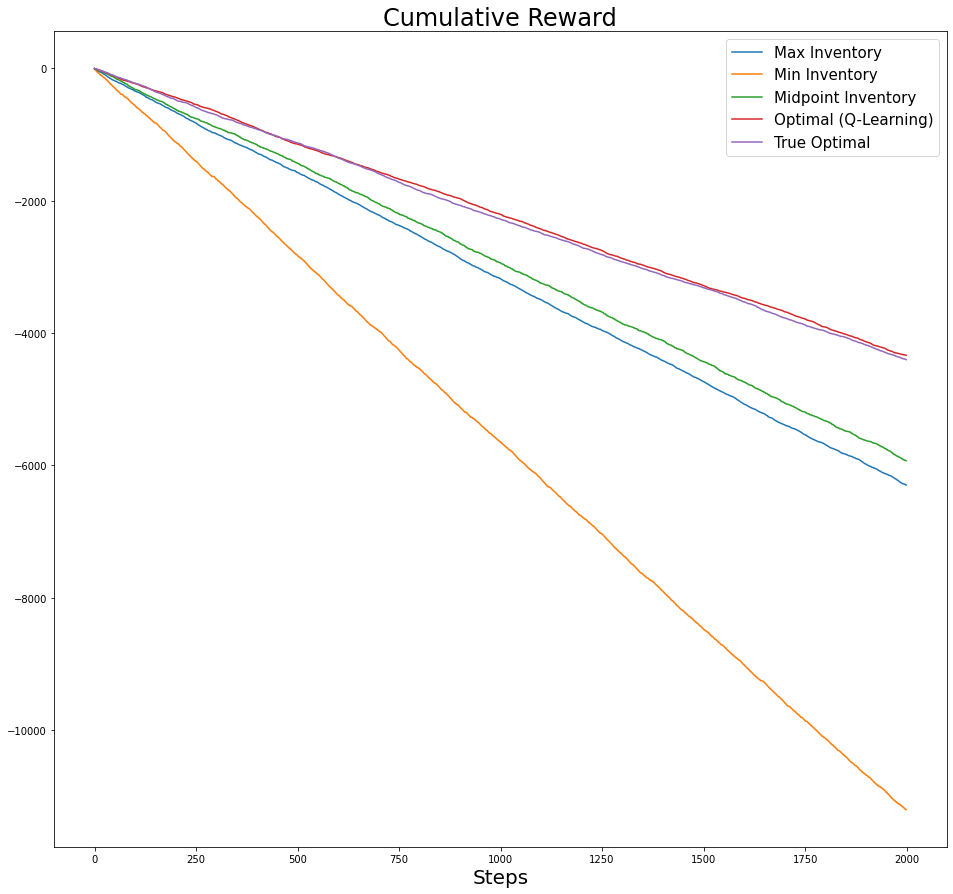

In [ ]:
fig,axs = plt.subplots(figsize=(16,15))
axs.set_xlabel('Steps', fontsize=20)
axs.set_title(f'Cumulative Reward', fontsize=24)
for i,cum_r in enumerate(plot_list):
  axs.plot(cum_r, label=label_list[i])
# axs.set_ylim([-5000,0])
axs.legend(fontsize=15);

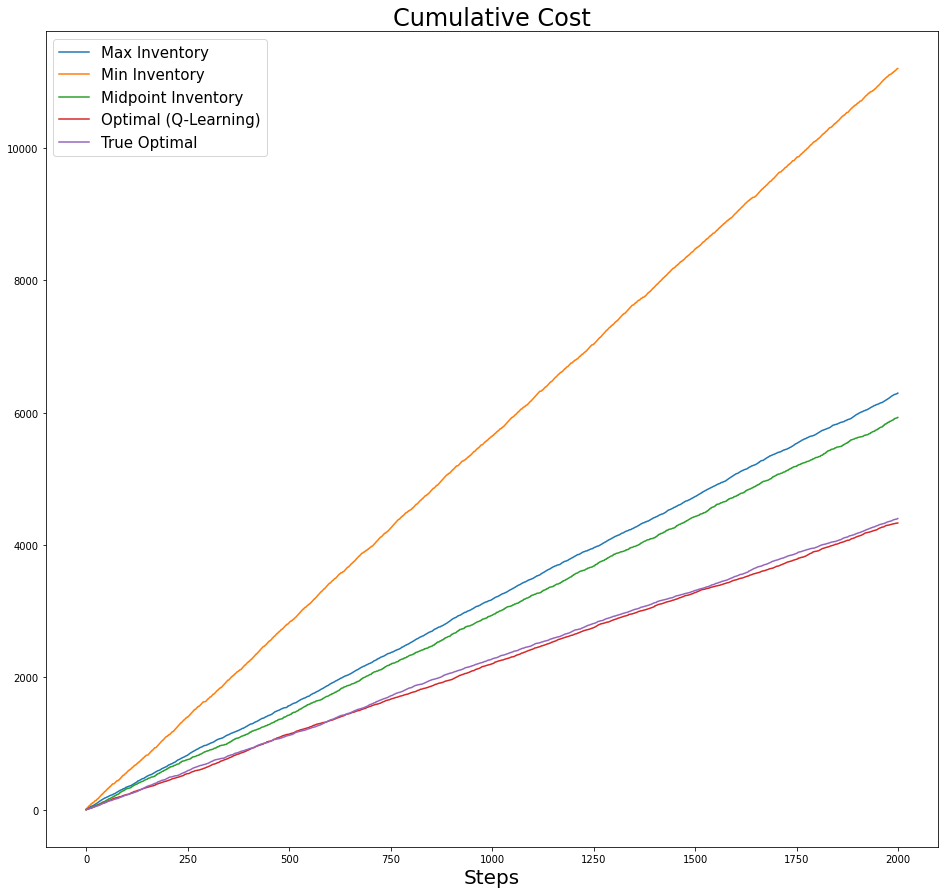

In [ ]:
fig,axs = plt.subplots(figsize=(16,15))
axs.set_xlabel('Steps', fontsize=20)
axs.set_title(f'Cumulative Cost', fontsize=24)
for i,cum_r in enumerate(plot_list):
  axs.plot(-cum_r, label=label_list[i])
# axs.set_ylim([0, 5000])
axs.legend(fontsize=15);

Now we zoom in a bit:

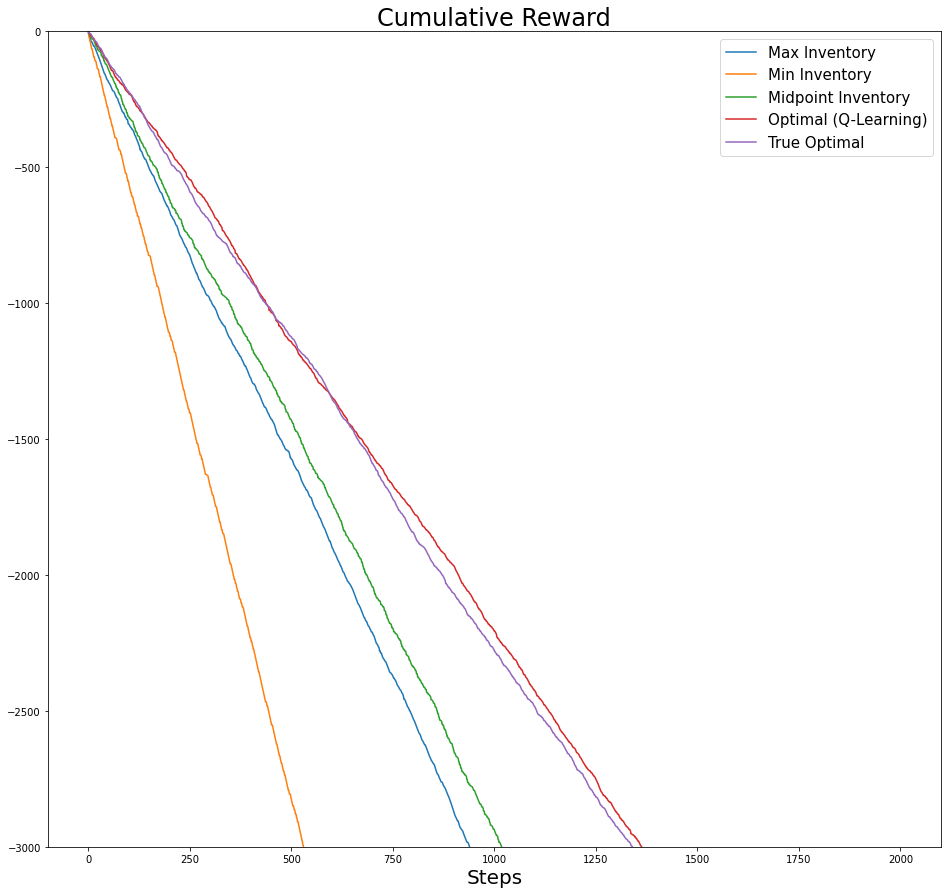

In [ ]:
fig,axs = plt.subplots(figsize=(16,15))
axs.set_xlabel('Steps', fontsize=20)
axs.set_title(f'Cumulative Reward', fontsize=24)
for i,cum_r in enumerate(plot_list):
  axs.plot(cum_r, label=label_list[i])
axs.set_ylim([-3000,0])
axs.legend(fontsize=15);

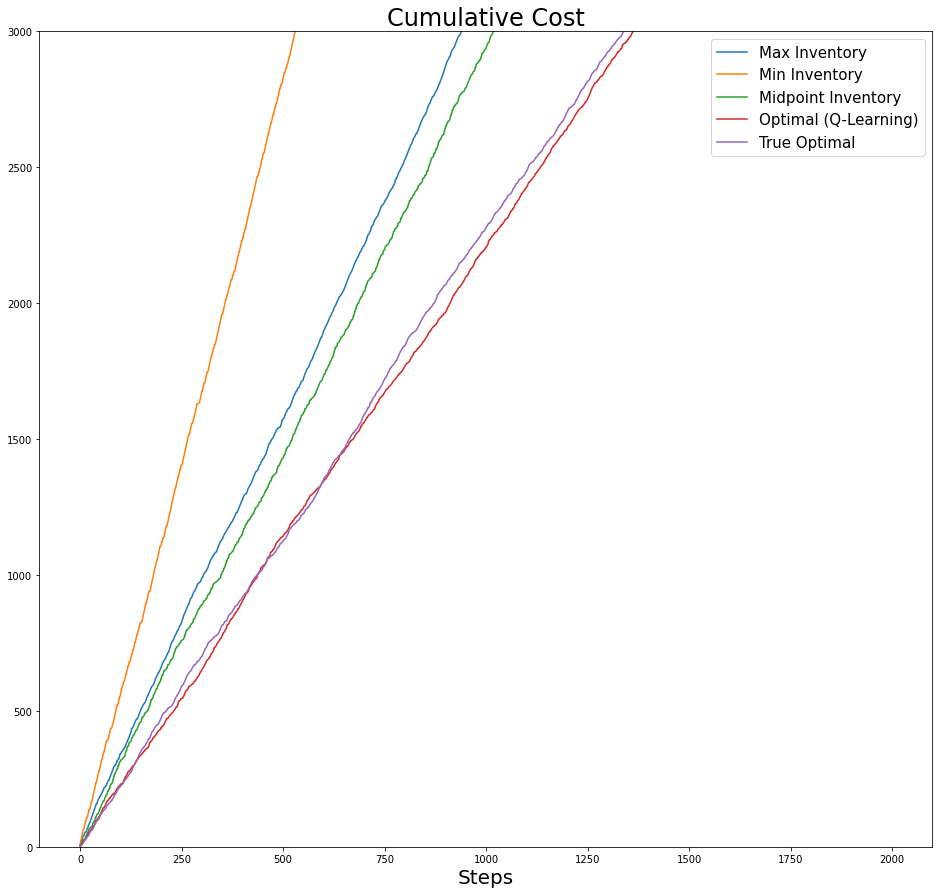

In [ ]:
fig,axs = plt.subplots(figsize=(16,15))
axs.set_xlabel('Steps', fontsize=20)
axs.set_title(f'Cumulative Cost', fontsize=24)
for i,cum_r in enumerate(plot_list):
  axs.plot(-cum_r, label=label_list[i])
axs.set_ylim([0, 3000])
axs.legend(fontsize=15);